In [1]:
import numpy as np
import pandas as pd
np.random.seed(8)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

import re
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('train.csv')
test_cm = pd.read_csv('test.csv')
test_lb = pd.read_csv('test_labels.csv')
test_all = pd.merge(test_cm, test_lb, on='id')
test = test_all[test_all['toxic'] != -1]

Using TensorFlow backend.


In [2]:
label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
X_train = train["comment_text"]
y_train = train[label_names].values
X_test = test["comment_text"]
y_test = test[label_names].values

In [3]:
# Define vocabulary size
vocab = 100000
# Define maximum length of a comment
maxlen = 200
# Define embedding size which should equal the embedding size of the pre-trained word vectors
embed_size = 300

In [4]:
'''# Removing ip address
X_train = X_train.apply(lambda x: re.sub("(?:[0-9]{1,3}\.){3}[0-9]{1,3}","",x))
X_test = X_test.apply(lambda x: re.sub("(?:[0-9]{1,3}\.){3}[0-9]{1,3}","",x))
# Removing url link
X_train = X_train.apply(lambda x: re.sub("http://.*com","",x))
X_test = X_test.apply(lambda x: re.sub("http://.*com","",x))
# Removing username
X_train = X_train.apply(lambda x: re.sub("\[\[.*\]","",x))
X_test = X_test.apply(lambda x: re.sub("\[\[.*\]","",x))'''

'# Removing ip address\nX_train = X_train.apply(lambda x: re.sub("(?:[0-9]{1,3}\\.){3}[0-9]{1,3}","",x))\nX_test = X_test.apply(lambda x: re.sub("(?:[0-9]{1,3}\\.){3}[0-9]{1,3}","",x))\n# Removing url link\nX_train = X_train.apply(lambda x: re.sub("http://.*com","",x))\nX_test = X_test.apply(lambda x: re.sub("http://.*com","",x))\n# Removing username\nX_train = X_train.apply(lambda x: re.sub("\\[\\[.*\\]","",x))\nX_test = X_test.apply(lambda x: re.sub("\\[\\[.*\\]","",x))'

In [5]:
'''# Filter out stop words
from nltk.corpus import stopwords

def filter_stop_words(sentences, stop_words):
    filtered = []
    for sentence in sentences:
        words = sentence.split()
        words_filtered = [word for word in words if word not in stop_words]
        filtered.append(" ".join(words_filtered))
    return filtered
 
stop_words = set(stopwords.words("english"))
 
# Comments in train
X_train_ = filter_stop_words(X_train, stop_words)
 
# Comments in test (excluding labels with -1 values)
X_test_ = filter_stop_words(X_test, stop_words)'''

'# Filter out stop words\nfrom nltk.corpus import stopwords\n\ndef filter_stop_words(sentences, stop_words):\n    filtered = []\n    for sentence in sentences:\n        words = sentence.split()\n        words_filtered = [word for word in words if word not in stop_words]\n        filtered.append(" ".join(words_filtered))\n    return filtered\n \nstop_words = set(stopwords.words("english"))\n \n# Comments in train\nX_train_ = filter_stop_words(X_train, stop_words)\n \n# Comments in test (excluding labels with -1 values)\nX_test_ = filter_stop_words(X_test, stop_words)'

In [6]:
# Tokenize the train dataset
t = text.Tokenizer(num_words=vocab)
t.fit_on_texts(list(X_train))

In [7]:
# Convert both train and test datasets into sequences
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [8]:
# Load pre-trained word vectors
EMBEDDING_FILE = 'crawl-300d-2M.vec'
embeddings_index = dict()
f = open(EMBEDDING_FILE)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s pre-trained words' % len(embeddings_index))


Loaded 2000000 pre-trained words


In [9]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab, embed_size))
for word, i in t.word_index.items():
    if i >= vocab: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [10]:
import tensorflow as tf
import keras.backend as K

# FROM https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/41108
def jacek_auc(y_true, y_pred):
   score, up_opt = tf.metrics.auc(y_true, y_pred)
   #score, up_opt = tf.contrib.metrics.streaming_auc(y_pred, y_true)    
   K.get_session().run(tf.local_variables_initializer())
   with tf.control_dependencies([up_opt]):
       score = tf.identity(score)
   return score

# FROM https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/41015
# AUC for a binary classifier
def tf_binary_auc(y_true, y_pred):
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)

#---------------------
# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.8)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)
    return FP/N

#----------------
# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.8)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)
    return TP/P

In [11]:
from sklearn.metrics import roc_auc_score
import keras
class RocAucMetricCallback(Callback):
    def __init__(self, train_data, predict_batch_size=1024, include_on_batch=False):
        super(RocAucMetricCallback, self).__init__()
        self.train_data=train_data
        self.predict_batch_size=predict_batch_size
        self.include_on_batch=include_on_batch

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        if(self.include_on_batch):
            logs['sklearn_auc']=float('-inf')
            logs['val_sklearn_auc']=float('-inf')
            if(self.train_data):
                logs['sklearn_auc']=roc_auc_score(self.train_data[1], 
                                                  self.model.predict(self.train_data[0],
                                                                     batch_size=self.predict_batch_size))
            if(self.validation_data):
                logs['val_sklearn_auc']=roc_auc_score(self.validation_data[1], 
                                                  self.model.predict(self.validation_data[0],
                                                                     batch_size=self.predict_batch_size))

    def on_train_begin(self, logs={}):
        if not ('sklearn_auc' in self.params['metrics']):
            self.params['metrics'].append('sklearn_auc')
        if not ('val_sklearn_auc' in self.params['metrics']):
            self.params['metrics'].append('val_sklearn_auc')

    def on_train_end(self, logs={}):
        pass

    def on_epoch_begin(self, epoch, logs={}):
        pass

    def on_epoch_end(self, epoch, logs={}):
        logs['sklearn_auc']=float('-inf')
        logs['val_sklearn_auc']=float('-inf')
        if(self.train_data):
            logs['sklearn_auc']=roc_auc_score(self.train_data[1], 
                                              self.model.predict(self.train_data[0],
                                                                 batch_size=self.predict_batch_size))
            print("- sklearn_auc: %.4f" % (logs['sklearn_auc']))    
        if(self.validation_data):
            logs['val_sklearn_auc']=roc_auc_score(self.validation_data[1], 
                                              self.model.predict(self.validation_data[0],
                                                                 batch_size=self.predict_batch_size))
            print("- val_sklearn_auc: %.4f" % (logs['val_sklearn_auc']))    

In [12]:
# Define make_model function to create a CNN model
def make_model(k=[2,3,4], activation='tanh', filters=32, Sdroprate=0.4, droprate=0.0):

    inp = Input(shape=(maxlen, ))
    x = Embedding(vocab, embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False)(inp)
    x = SpatialDropout1D(Sdroprate)(x)
    x = Reshape((maxlen, embed_size, 1))(x)
    
    conv = dict()
    maxpool = dict()
    for h in k:
        conv[h] = Conv2D(filters, kernel_size=(h, embed_size), activation=activation)(x)
        maxpool[h] = MaxPool2D(pool_size=(maxlen - h + 1, 1))(conv[h])
    if len(k) == 1:
        y = maxpool[h]
    else:
        y = Concatenate(axis=1)([pool for key,pool in maxpool.items()])
    y = Flatten()(y)
    y = Dropout(droprate)(y)

    outp = Dense(6, activation="sigmoid")(y)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf_binary_auc])
    
    return model
model = make_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     30000000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 200, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 200, 300, 1)  0           spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [13]:
# Split the train dataset into train and validation datasets
x_trainS, x_val, y_trainS, y_val = train_test_split(x_train, y_train, train_size=0.90, random_state=8)

In [14]:
# Set batch_size, epochs parameters
# Define file_path to store best model
# Create instance of check_point, early_stop and roc_auc
from keras.callbacks import ModelCheckpoint, EarlyStopping
batch_size=256
epochs = 10
file_path = 'saved_models/weights.best.hdf5'
check_point = ModelCheckpoint(filepath=file_path, monitor = 'val_sklearn_auc', mode="max", verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor = 'val_sklearn_auc', mode = "max", patience = 2, verbose=2)
roc_auc = RocAucMetricCallback(train_data=(x_trainS, y_trainS))
#cb = [roc_auc, early_stop, check_point]
cb = [roc_auc, check_point]

In [15]:
# Fit the model with the train and validation datasets
from keras.wrappers.scikit_learn import KerasClassifier
estimator = KerasClassifier(make_model,epochs=epochs,batch_size=batch_size,verbose=1)
h = estimator.fit(x_trainS, y_trainS, validation_data=(x_val, y_val), callbacks=cb)

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 484s 3ms/step - loss: 0.0875 - tf_binary_auc: 0.9315 - val_loss: 0.0487 - val_tf_binary_auc: 0.9861
- sklearn_auc: 0.9777
- val_sklearn_auc: 0.9789

Epoch 00001: val_sklearn_auc improved from -inf to 0.97894, saving model to saved_models/weights.best.hdf5
Epoch 2/10
143613/143613 [==============================] - 422s 3ms/step - loss: 0.0501 - tf_binary_auc: 0.9845 - val_loss: 0.0442 - val_tf_binary_auc: 0.9886
- sklearn_auc: 0.9848
- val_sklearn_auc: 0.9850

Epoch 00002: val_sklearn_auc improved from 0.97894 to 0.98497, saving model to saved_models/weights.best.hdf5
Epoch 3/10
143613/143613 [==============================] - 422s 3ms/step - loss: 0.0463 - tf_binary_auc: 0.9872 - val_loss: 0.0427 - val_tf_binary_auc: 0.9889
- sklearn_auc: 0.9877
- val_sklearn_auc: 0.9865

Epoch 00003: val_sklearn_auc improved from 0.98497 to 0.98651, saving model to saved_models/weights.best.

In [16]:
from keras.models import load_model
model_saved = load_model(file_path, custom_objects={'tf_binary_auc': tf_binary_auc})
model_saved.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 300)     30000000    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 200, 300)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 200, 300, 1)  0           spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
conv2d_4 (

In [17]:
y_pred = model_saved.predict(x_test, batch_size=batch_size)
score = roc_auc_score(y_test, y_pred)
print("\n roc_auc score: %.6f \n" % (score))


 roc_auc score: 0.982016 



toxic label tpr > 0.98: 0.0732
toxic label fpr < 0.10: 0.3717


<Figure size 720x576 with 0 Axes>

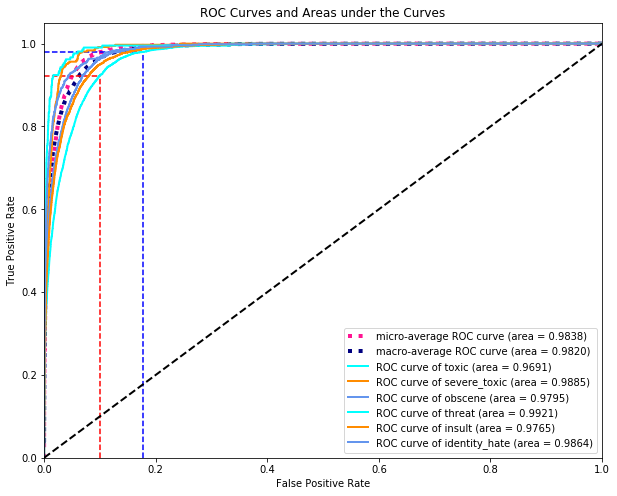

In [18]:
# Compute ROC curves and AUCs for test
from sklearn.metrics import roc_curve, auc
from scipy import interp

# Compute false positive rate (fpr), true positive rate (tpr) and area under the curves (rocauc)
fpr = dict()
tpr = dict()
thr = dict()
rocauc = dict()
for i in range(y_test.shape[1]):
    fpr[i], tpr[i], thr[i] = roc_curve(y_test[:, i], y_pred[:, i])
    rocauc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thr["micro"] = roc_curve(y_test.ravel(), y_pred.ravel())
rocauc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute Macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_test.shape[1])]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(y_test.shape[1]):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= y_test.shape[1]

# Then interpolate all ROC curves at this points
mean_thr = np.zeros_like(all_fpr)
for i in range(y_test.shape[1]):
    mean_thr += interp(all_fpr, fpr[i], thr[i])

# Finally average it and compute AUC
mean_thr /= y_test.shape[1]

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
thr["macro"] = mean_thr
rocauc["macro"] = auc(fpr["macro"], tpr["macro"])

# to increase tpr, you also increase fpr. It is a trade off between the two.
# Business requirement determine which one is more important
# We can calculate the threshold to garantee a minimum tpr or a maximum fpr
# We see here that to increase tpr, we need to lower threshold
# to decrease fpr, we need to increase threshold

tpr_cut = 0.98
fpr_cut = 0.10

# index of the first threshold for which the sensitivity > tpr_cut
idx1 = np.min(np.where(tpr["micro"] > tpr_cut)) 
# index of the first threshold for which the fall out < fpr_cut
idx2 = np.max(np.where(fpr["micro"] < fpr_cut)) 
# index of the first threshold for which the sensitivity > tpr_cut
idx3 = np.min(np.where(tpr["macro"] > tpr_cut)) 
# index of the first threshold for which the fall out < fpr_cut
idx4 = np.max(np.where(fpr["macro"] < fpr_cut)) 
# index of the first threshold for which the sensitivity > tpr_cut
idx5 = np.min(np.where(tpr[0] > tpr_cut)) 
# index of the first threshold for which the fall out < fpr_cut
idx6 = np.max(np.where(fpr[0] < fpr_cut)) 

'''
print("Micro Average tpr > %.2f: %.4f" % (tpr_cut,thr["micro"][idx1]))
print("Micro Average fpr < %.2f: %.4f" % (fpr_cut,thr["micro"][idx2]))
print("Macro Average tpr > %.2f: %.4f" % (tpr_cut,thr["macro"][idx3]))
print("Macro Average fpr < %.2f: %.4f" % (fpr_cut,thr["macro"][idx4]))
'''
print("toxic label tpr > %.2f: %.4f" % (tpr_cut,thr[0][idx5]))
print("toxic label fpr < %.2f: %.4f" % (fpr_cut,thr[0][idx6]))

# Plot all ROC curves
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import cycle

plt.figure(figsize=(10,8))
lw = 2

plt.figure(figsize=(10,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(rocauc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(rocauc["macro"]),
         color='navy', linestyle=':', linewidth=4)
'''
plt.plot([0,fpr["micro"][idx1]], [tpr["micro"][idx1],tpr["micro"][idx1]], 'k--', color='blue')
plt.plot([fpr["micro"][idx1],fpr["micro"][idx1]], [0,tpr["micro"][idx1]], 'k--', color='blue')

plt.plot([0,fpr["micro"][idx2]], [tpr["micro"][idx2],tpr["micro"][idx2]], 'k--', color='red')
plt.plot([fpr["micro"][idx2],fpr["micro"][idx2]], [0,tpr["micro"][idx2]], 'k--', color='red')

plt.plot([0,fpr["macro"][idx3]], [tpr["macro"][idx3],tpr["macro"][idx3]], 'k--', color='blue')
plt.plot([fpr["macro"][idx3],fpr["macro"][idx3]], [0,tpr["macro"][idx3]], 'k--', color='blue')

plt.plot([0,fpr["macro"][idx4]], [tpr["macro"][idx4],tpr["macro"][idx4]], 'k--', color='red')
plt.plot([fpr["macro"][idx4],fpr["macro"][idx4]], [0,tpr["macro"][idx4]], 'k--', color='red')
'''
plt.plot([0,fpr[0][idx5]], [tpr[0][idx5],tpr[0][idx5]], 'k--', color='blue')
plt.plot([fpr[0][idx5],fpr[0][idx5]], [0,tpr[0][idx5]], 'k--', color='blue')

plt.plot([0,fpr[0][idx6]], [tpr[0][idx6],tpr[0][idx6]], 'k--', color='red')
plt.plot([fpr[0][idx6],fpr[0][idx6]], [0,tpr[0][idx6]], 'k--', color='red')

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(y_test.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.4f})'
             ''.format(label_names[i], rocauc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves and Areas under the Curves')
plt.legend(loc="lower right")
plt.show()

In [19]:
# Visualize training history
import matplotlib.pyplot as plt
import numpy

# list all data in history
print(h.history.keys())

dict_keys(['val_loss', 'val_tf_binary_auc', 'loss', 'tf_binary_auc', 'sklearn_auc', 'val_sklearn_auc'])


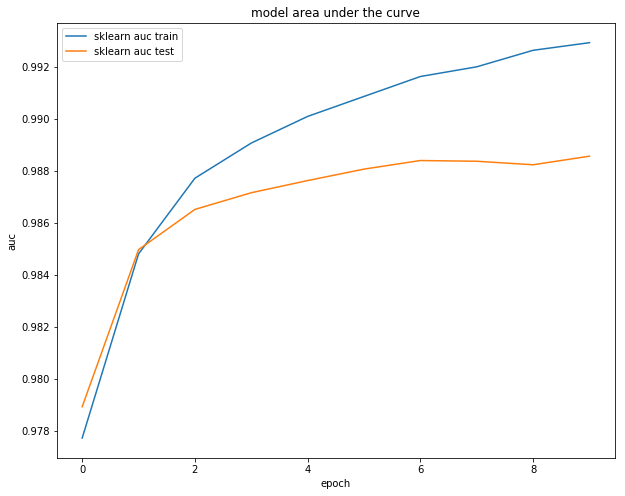

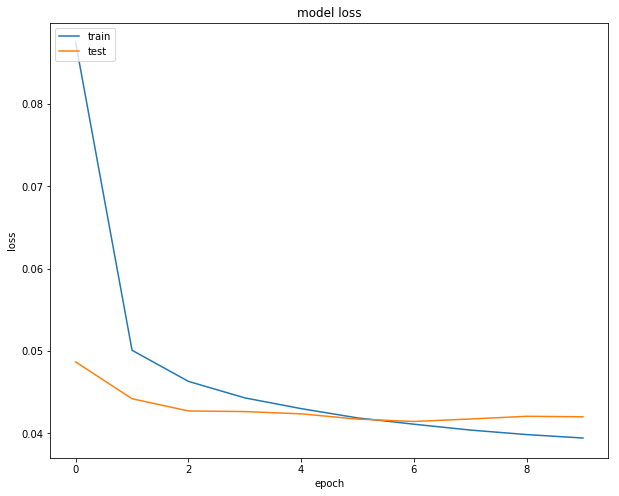

In [20]:
# summarize history for accuracy
plt.figure(figsize=(10,8))
#plt.plot(h.history['tf_binary_auc'])
#plt.plot(h.history['val_tf_binary_auc'])
plt.plot(h.history['sklearn_auc'])
plt.plot(h.history['val_sklearn_auc'])
plt.title('model area under the curve')
plt.ylabel('auc')
plt.xlabel('epoch')
#plt.legend(['tf binary auc train', 'tf binary auc test', 'sklearn auc train', 'sklearn auc test'], loc='upper left')
plt.legend(['sklearn auc train', 'sklearn auc test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(10,8))
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()